In [1]:
import os
from os.path import join as opj

In [2]:
import nipype.interfaces.fsl.preprocess as ni_fsl_preproc
import nipype.interfaces.ants as ni_ants
import nipype.interfaces.freesurfer as ni_fs
import nipype.interfaces.afni as ni_afni
import nipype.interfaces.utility as ni_util # IdentityInterface
import nipype.interfaces.io as ni_io # SelectFiles, DataSink
import nipype.pipeline.engine as ni_engine # Workflow, Node

In [3]:
experiment_dir = '/home/dave/Temp/nhw_test/wmh_derivatives'
output_dir = 'datasink'
working_dir = 'wd'

In [5]:
# ANTs: Rigid registration of T1 to FLAIR
ants_reg = ni_engine.Node(ni_ants.Registration(dimension=3,
                                               transforms=['Rigid'],
                                               transform_parameters=[(0.1,)],
                                               metric=['MI'],
                                               metric_weight=[1.0],
                                               number_of_iterations=[[1000]],
                                               convergence_threshold=[1.e-6],
                                               convergence_window_size=[10],
                                               shrink_factors=[[4]],
                                               smoothing_sigmas=[[2.]],
                                               # write_composite_transform=True,
                                               output_warped_image=True,
                                               output_transform_prefix='T1w_to_FLAIR'),
                         name='ants_reg')
# BET: skullstrip T1
bet_t1 = ni_engine.Node(ni_fsl_preproc.BET(frac=0.3,
                                           robust=True,
                                           output_type='NIFTI_GZ',
                                           mask=True),
                        name="bet_t1")

ants_warp = ni_engine.Node(ni_ants.ApplyTransforms(dimension=3,
                                                     interpolation='NearestNeighbor',
                                                     invert_transform_flags=[True],
                                                          default_value=0),
                                  name='ants_warp')

bias_correct_t1_fs_nucorrect = ni_engine.Node(ni_fs.MNIBiasCorrection(),
                                             name='bias_correct_t1_fs_nucorrect')
# bias_correct_t1_ants_atropos = ni_engine.Node(ni_ants.Atropos(TK))
bias_correct_t1_ants_n4 = ni_engine.Node(ni_ants.N4BiasFieldCorrection(),
                                        name='bias_correct_t1_ants_n4')
copy_t1 = ni_engine.Node(ni_afni.Copy(outputtype='NIFTI_GZ'),
                        name='copy_t1')

170907-00:39:22,718 interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


In [11]:
# Manually defined lists for now
site_top_list = ('Amst',)
site_bot_list = ('GE3T',)
sub_list = ('100', '101', '102')
#sub_list = ('100',)


# Infosource
infosource = ni_engine.Node(ni_util.IdentityInterface(fields=['site_top', 'site_bot', 'subject_id']),
                  name="infosource")
infosource.iterables = [('site_top', site_top_list),
                        ('site_bot', site_bot_list),
                        ('subject_id', sub_list)]

# SelectFiles
t1_file = opj('wmh', '{site_top}', '{site_bot}', '{subject_id}', 'orig', '3DT1.nii.gz')
flair_file = opj('wmh', '{site_top}', '{site_bot}',
                 '{subject_id}', 'orig', 'FLAIR.nii.gz')
lesion_file = opj('wmh', '{site_top}', '{site_bot}',
                  '{subject_id}', 'wmh.nii.gz')

templates = {'t1': t1_file,
             'flair': flair_file,
             'lesion': lesion_file}
selectfiles = ni_engine.Node(ni_io.SelectFiles(templates,
                                               base_directory='/home/dave/Temp/nhw_test',
                                               sort_filelist=True),
                             name="selectfiles")
                            
# Datasink - creates output folder for important outputs
ds_resubs = [(r'_site_bot_(?P<site_bot>.*)_site_top_(?P<site_top>.*)_subject_id_(?P<subject_id>\d+)',
              r'sub-\g<site_top>\g<subject_id>'),
             (r'3DT1\.nii\.gz', r'T1w_base.nii.gz'),
             (r'3DT1', r'T1w'),
             (r'_corrected', '_bias_corrected_ants_n4'),
             (r'_output', '_bias_corrected_fs_nucorrect'),
             (r'wmh_trans', r'lesion_mask_t1'),
             ('_copy', '_base')
            ]
datasink = ni_engine.Node(ni_io.DataSink(base_directory=experiment_dir,
                                         container=output_dir,
                                         regexp_substitutions=ds_resubs),
                          name="datasink")

In [12]:
# Create the preprocessing workflow
preproc = ni_engine.Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('site_top', 'site_top'),
                                            ('site_bot', 'site_bot'),
                                            ('subject_id', 'subject_id')]),
                 (selectfiles, copy_t1, [('t1', 'in_file')]),
                 (selectfiles, bet_t1, [('t1', 'in_file')]),
                 (selectfiles, bias_correct_t1_ants_n4, [('t1', 'input_image')]),
                 (bet_t1, bias_correct_t1_ants_n4, [('mask_file', 'mask_image')]),                 
                 (selectfiles, bias_correct_t1_fs_nucorrect, [('t1', 'in_file')]),
                 (bet_t1, bias_correct_t1_fs_nucorrect, [('mask_file', 'mask')]),                 
                 (selectfiles, ants_reg, [('t1', 'moving_image'),
                                          ('flair', 'fixed_image')]),
                 (ants_reg, ants_warp, [('reverse_transforms', 'transforms')]),
                 (selectfiles, ants_warp, [('t1', 'reference_image'),
                                           ('lesion', 'input_image')]),
                 (bet_t1, datasink, [('out_file', 'preproc'),
                                     ('mask_file', 'preproc.@mask')]),
                 (ants_reg, datasink, [('composite_transform', 'preproc.@t1_to_flair_tf'),
                                       ('inverse_composite_transform', 'preproc.@flair_to_t1_tf')]),
                 (ants_warp, datasink, [('output_image', 'preproc.@lesion_to_t1_nii')]),
                 (bias_correct_t1_ants_n4, datasink, [('output_image', 'preproc.@bc_ants_n4_t1')]),
                 (bias_correct_t1_fs_nucorrect, datasink, [('out_file', 'preproc.@bc_nucorrect_t1')]),
                 (copy_t1, datasink, [('out_file', 'preproc.@t1_base')]),
                 ])

170907-00:40:40,897 workflow INFO:
	 Generated workflow graph: /home/dave/Temp/nhw_test/wmh_derivatives/wd/preproc/graph.dot.png (graph2use=colored, simple_form=True).


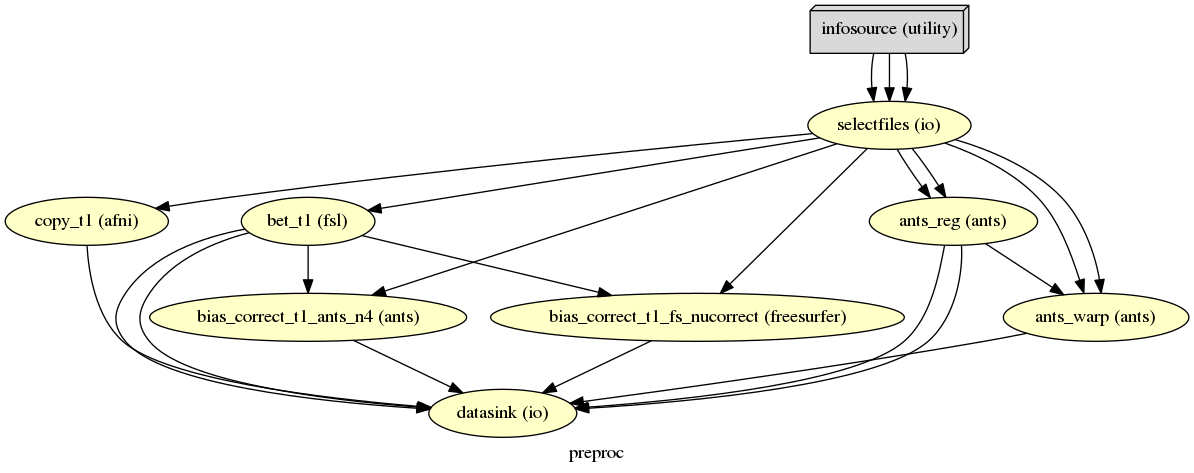

In [13]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
import IPython.display
IPython.display.Image(filename=opj(preproc.base_dir, 'preproc', 'graph.dot.png'))

In [14]:
preproc.run('MultiProc', plugin_args={'n_procs': 1})

170907-00:40:41,819 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170907-00:40:41,858 workflow INFO:
	 Running in parallel.
170907-00:40:41,864 workflow INFO:
	 Executing: selectfiles.a2 ID: 0
170907-00:40:41,868 workflow INFO:
	 Executing node selectfiles.a2 in dir: /home/dave/Temp/nhw_test/wmh_derivatives/wd/preproc/_site_bot_GE3T_site_top_Amst_subject_id_102/selectfiles
170907-00:40:41,891 workflow INFO:
	 [Job finished] jobname: selectfiles.a2 jobid: 0
170907-00:40:41,896 workflow INFO:
	 Executing: copy_t1.a2 ID: 1
170907-00:40:41,901 workflow INFO:
	 [Job finished] jobname: copy_t1.a2 jobid: 1
170907-00:40:41,907 workflow INFO:
	 Executing: bet_t1.a2 ID: 2
170907-00:40:41,913 workflow INFO:
	 [Job finished] jobname: bet_t1.a2 jobid: 2
170907-00:40:41,918 workflow INFO:
	 Executing: bias_correct_t1_ants_n4.a2 ID: 3
170907-00:40:41,924 workflow INFO:
	 [Job finished] jobname: bias_correct_t1_ants_n4.a2 jobid: 3
170907-00:40:41,930 workflow INFO:
	 Ex

	 sub: /home/dave/Temp/nhw_test/wmh_derivatives/datasink/preproc/_site_bot_GE3T_site_top_Amst_subject_id_100/3DT1_copy.nii.gz -> /home/dave/Temp/nhw_test/wmh_derivatives/datasink/preproc/sub-Amst100/T1w_base.nii.gz
170907-00:40:42,310 interface INFO:
	 sub: /home/dave/Temp/nhw_test/wmh_derivatives/datasink/preproc/_site_bot_GE3T_site_top_Amst_subject_id_100/3DT1_brain.nii.gz -> /home/dave/Temp/nhw_test/wmh_derivatives/datasink/preproc/sub-Amst100/T1w_brain.nii.gz
170907-00:40:42,317 interface INFO:
	 sub: /home/dave/Temp/nhw_test/wmh_derivatives/datasink/preproc/_site_bot_GE3T_site_top_Amst_subject_id_100/3DT1_brain_mask.nii.gz -> /home/dave/Temp/nhw_test/wmh_derivatives/datasink/preproc/sub-Amst100/T1w_brain_mask.nii.gz
170907-00:40:42,326 interface INFO:
	 sub: /home/dave/Temp/nhw_test/wmh_derivatives/datasink/preproc/_site_bot_GE3T_site_top_Amst_subject_id_100/3DT1_corrected.nii.gz -> /home/dave/Temp/nhw_test/wmh_derivatives/datasink/preproc/sub-Amst100/T1w_bias_corrected_ants_n4.ni